In [ ]:
!pip install pyproj

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import uuid
import random
import datetime

spark = SparkSession.builder \
    .appName("SmartLitter") \
    .getOrCreate()

jdbc_url = "jdbc:postgresql://db:5432/litter_db"
connection_properties = {
    "user": "root",
    "password": "pwd123",
    "driver": "org.postgresql.Driver",
    "stringtype": "unspecified"
}

I liebe patricia


In [2]:
bins_df = spark.read.jdbc(
    url=jdbc_url,
    table="litter_bin_geoposition",
    properties=connection_properties
)
bins_df.head(3)

[Row(litter_bin_uuid='0fd959ef-c165-4346-a1a3-cf32b9c00c8f', geom_point='01010000200808000091ED7C2FACB943411283C08A239E3241', fk_type_uuid='8ecccfc2-9444-4078-9082-a7744a699de3', archive=False, creation_date=datetime.date(2022, 6, 2), end_date=None, active=True, fastnacht=0, braderie=0, christmas_market=0, barbecue_season=0, bin_full=False, robidog_empty=False, ashtray_full=False, defect=False, dirty=False, id_nr=1),
 Row(litter_bin_uuid='2e4f4164-72ec-4557-b37f-6015cefd5057', geom_point='010100002008080000A8C64B67C6BA434146B6F3DD949B3241', fk_type_uuid='8ecccfc2-9444-4078-9082-a7744a699de3', archive=False, creation_date=datetime.date(2022, 6, 2), end_date=None, active=True, fastnacht=0, braderie=0, christmas_market=0, barbecue_season=0, bin_full=False, robidog_empty=False, ashtray_full=False, defect=False, dirty=False, id_nr=2),
 Row(litter_bin_uuid='455a9c45-c18a-48a2-8edd-029c0de1a492', geom_point='010100002008080000F0A7C6FB7CB84341F6285CCF1C9E3241', fk_type_uuid='8ecccfc2-9444-4078

In [4]:
litter_bin_uuids = [row['litter_bin_uuid'] for row in bins_df.select('litter_bin_uuid').collect()]
litter_bin_uuids[0:3]

[Row(litter_bin_uuid='0fd959ef-c165-4346-a1a3-cf32b9c00c8f', geom_point='01010000200808000091ED7C2FACB943411283C08A239E3241', fk_type_uuid='8ecccfc2-9444-4078-9082-a7744a699de3', archive=False, creation_date=datetime.date(2022, 6, 2), end_date=None, active=True, fastnacht=0, braderie=0, christmas_market=0, barbecue_season=0, bin_full=False, robidog_empty=False, ashtray_full=False, defect=False, dirty=False, id_nr=1)]

In [6]:
bins_df.head(1)

In [ ]:
from pyspark.sql.functions import udf, col
from pyproj import Transformer
import struct
import binascii


def extract_lat_lon(geom_point_hex):
    if geom_point_hex is None:
        return None, None
    try:
        body = geom_point_hex[18:]  # Skip the header and SRID
        body_bytes = binascii.unhexlify(body)
        x, y = struct.unpack('<dd', body_bytes)
        transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326")
        longitude, latitude = transformer.transform(x, y)
        return longitude, latitude
    except Exception as _:
        return None, None

extract_lat_udf = udf(lambda geom_point_hex: extract_lat_lon(geom_point_hex)[0], DoubleType())
extract_lon_udf = udf(lambda geom_point_hex: extract_lat_lon(geom_point_hex)[1], DoubleType())

bins_df = bins_df.withColumn('latitude', extract_lat_udf(col('geom_point')))
bins_df = bins_df.withColumn('longitude', extract_lon_udf(col('geom_point')))

## Event Periods

In [8]:
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=365)

years = set()
current_date = start_date
while current_date <= end_date:
    years.add(current_date.year)
    current_date += datetime.timedelta(days=1)
years = sorted(list(years))


In [9]:
def get_event_periods(year):
    # Fastnacht: First two weeks of February
    fastnacht_start = datetime.datetime(year, 2, 1)
    fastnacht_end = datetime.datetime(year, 2, 14)

    # Braderie: Last weekend of June (Friday to Sunday)
    last_day_of_june = datetime.datetime(year, 6, 30)
    weekday = last_day_of_june.weekday()
    last_sunday = last_day_of_june - datetime.timedelta(days=weekday)
    last_friday = last_sunday - datetime.timedelta(days=2)
    braderie_start = last_friday
    braderie_end = last_sunday

    # Christmas Market: December 1st to December 25th
    christmas_market_start = datetime.datetime(year, 12, 1)
    christmas_market_end = datetime.datetime(year, 12, 25)

    # Barbecue Season: Random days during summer (June 1st to August 31st)
    summer_start = datetime.datetime(year, 6, 1)
    summer_end = datetime.datetime(year, 8, 31)
    all_summer_days = [
        summer_start + datetime.timedelta(days=x)
        for x in range((summer_end - summer_start).days + 1)
    ]
    num_barbecue_days = 40
    barbecue_season_days = random.sample(all_summer_days, num_barbecue_days)
    barbecue_season_dates = set(day.date() for day in barbecue_season_days)

    return {
        'fastnacht': (fastnacht_start, fastnacht_end),
        'braderie': (braderie_start, braderie_end),
        'christmas_market': (christmas_market_start, christmas_market_end),
        'barbecue_season': barbecue_season_dates
    }


In [10]:
event_periods = {
    'fastnacht': [],
    'braderie': [],
    'christmas_market': [],
    'barbecue_season': set()
}

for year in years:
    periods = get_event_periods(year)
    event_periods['fastnacht'].append((periods['fastnacht'][0], periods['fastnacht'][1]))
    event_periods['braderie'].append((periods['braderie'][0], periods['braderie'][1]))
    event_periods['christmas_market'].append((periods['christmas_market'][0], periods['christmas_market'][1]))
    event_periods['barbecue_season'].update(periods['barbecue_season'])

In [ ]:
def is_within_event(date, event_name):
    if event_name == 'barbecue_season':
        return date.date() in event_periods['barbecue_season']
    else:
        for start, end in event_periods[event_name]:
            if start.date() <= date.date() <= end.date():
                return True
        return False


## Bin Locations

In [12]:
inner_square_coords = {
    'NE': (47.13728128322776, 7.251077168095663),
    'SE': (47.13064665584864, 7.251077168095663),
    'SW': (47.13064665584864, 7.239448953585693),
    'NW': (47.13728128322776, 7.239448953585693)
}

outer_square_coords = {
    'NE': (47.17383740918423, 7.304050348858962),
    'SE': (47.10951331580206, 7.304050348858962),
    'SW': (47.10951331580206, 7.22305712226566),
    'NW': (47.17383740918423, 7.22305712226566)
}

def get_square_bounds(square_coords):
    lats = [coord[0] for coord in square_coords.values()]
    lons = [coord[1] for coord in square_coords.values()]
    return {
        'min_lat': min(lats),
        'max_lat': max(lats),
        'min_lon': min(lons),
        'max_lon': max(lons)
    }

def is_within_square(lat, lon, bounds):
    return (bounds['min_lat'] <= lat <= bounds['max_lat']) and (bounds['min_lon'] <= lon <= bounds['max_lon'])

inner_square_bounds = get_square_bounds(inner_square_coords)
outer_square_bounds = get_square_bounds(outer_square_coords)

In [13]:
is_in_inner_square_udf = udf(
    lambda lat, lon: is_within_square(lat, lon, inner_square_bounds),
    BooleanType()
)

is_in_outer_square_udf = udf(
    lambda lat, lon: is_within_square(lat, lon, outer_square_bounds),
    BooleanType()
)

bins_df = bins_df.withColumn(
    'is_in_inner_square',
    is_in_inner_square_udf(col('latitude'), col('longitude'))
)

bins_df = bins_df.withColumn(
    'is_in_outer_square',
    is_in_outer_square_udf(col('latitude'), col('longitude'))
)

In [14]:
bins_df.head(1)

[Row(litter_bin_uuid='0fd959ef-c165-4346-a1a3-cf32b9c00c8f', geom_point='01010000200808000091ED7C2FACB943411283C08A239E3241', fk_type_uuid='8ecccfc2-9444-4078-9082-a7744a699de3', archive=False, creation_date=datetime.date(2022, 6, 2), end_date=None, active=True, fastnacht=0, braderie=0, christmas_market=0, barbecue_season=0, bin_full=False, robidog_empty=False, ashtray_full=False, defect=False, dirty=False, id_nr=1, latitude=47.132004224182516, longitude=7.246619818672296, is_in_inner_square=True, is_in_outer_square=True)]

## Generate test data

In [15]:
bin_types_df = spark.read.jdbc(
    url=jdbc_url,
    table="litter_bin_type",
    properties=connection_properties
)

bins_with_types_df = bins_df.join(
    bin_types_df,
    bins_df.fk_type_uuid == bin_types_df.type_uuid,
    'left'
).select(
    bins_df["*"],
    bin_types_df["volume"]
)

bin_type_volume = {
    row['type_uuid']: row['volume']
    for row in bin_types_df.collect()
}


In [16]:
def get_full_notifications_count(row, current, event):
    inner_square = row['is_in_inner_square']
    outer_square = row['is_in_outer_square']
    weekday = current.weekday()  # Monday is 0, Sunday is 6

    if inner_square:
        if event:
            # During events: 7 to 30 notifications
            return random.randint(7, 30)
        elif weekday >= 5:
            # Weekends: 2 to 15 notifications
            return random.randint(2, 15)
        else:
            # Weekdays: 0 to 4 notifications
            return random.randint(0, 4)
    elif outer_square:
        # 0 or 1 notification per day, more likely 0
        return random.choices([0, 1], weights=[0.7, 0.3])[0]
    else:
        # Bins outside both squares: no notifications or set a default
        return 0


In [17]:
bin_state_notification_rows = []
bins_full_notification_dates = {}

bins = bins_with_types_df.collect()

# Generate "full" events
for bin_row in bins:
    bin_uuid = bin_row['litter_bin_uuid']
    fk_type_uuid = bin_row['fk_type_uuid']
    bin_volume = bin_type_volume.get(fk_type_uuid, 50)  # Default to 50 if not found

    current_date = start_date
    while current_date <= end_date:
        events_today = []
        # Check for events affecting the bin today
        if bin_row['fastnacht'] and is_within_event(current_date, 'fastnacht'):
            events_today.append('fastnacht')
        if bin_row['braderie'] and is_within_event(current_date, 'braderie'):
            events_today.append('braderie')
        if bin_row['christmas_market'] and is_within_event(current_date, 'christmas_market'):
            events_today.append('christmas_market')
        if bin_row['barbecue_season'] and is_within_event(current_date, 'barbecue_season'):
            events_today.append('barbecue_season')

        # Determine if an event is happening today for this bin
        event_happening = len(events_today) > 0

        num_full_notifications = get_full_notifications_count(bin_row, current_date, event_happening)

        for _ in range(num_full_notifications):
            notification_uuid = str(uuid.uuid4())
            fk_litter_bin_uuid = bin_uuid
            volume = bin_volume  # Assuming bin is full
            # Random time during the day (00:00 to 23:59)
            hour = random.randint(0, 23)
            minute = random.randint(0, 59)
            point_in_time = datetime.datetime.combine(
                current_date.date(),
                datetime.time(hour=hour, minute=minute)
            )
            bin_state_notification_rows.append((notification_uuid, fk_litter_bin_uuid, point_in_time, 'full', volume))

        # Record if the bin received a 'full' notification today
        if num_full_notifications > 0:
            if bin_uuid not in bins_full_notification_dates:
                bins_full_notification_dates[bin_uuid] = set()
            bins_full_notification_dates[bin_uuid].add(current_date.date())

        # Move to the next day
        current_date += datetime.timedelta(days=1)

# Generate "emptying" events (if on the day before at 04:30 a full event occured a emptying event gets appended)
for bin_uuid in bins_full_notification_dates:
    full_notification_dates = bins_full_notification_dates[bin_uuid]
    for date in full_notification_dates:
        # Next day
        next_day = date + datetime.timedelta(days=1)
        if next_day > end_date.date():
            continue  # Skip if next day is beyond the end date
        # Generate 'emptied' notification between 04:30 and 13:00
        hour = random.randint(4, 12)
        if hour == 4:
            minute = random.randint(30, 59)
        else:
            minute = random.randint(0, 59)
        point_in_time = datetime.datetime.combine(
            next_day,
            datetime.time(hour=hour, minute=minute)
        )
        notification_uuid = str(uuid.uuid4())
        fk_litter_bin_uuid = bin_uuid
        volume = 0  # Assuming bin is emptied
        bin_state_notification_rows.append((notification_uuid, fk_litter_bin_uuid, point_in_time, 'emptied', volume))

bin_state_notification_schema = StructType([
    StructField("state_uuid", StringType(), False),
    StructField("litter_bin_uuid", StringType(), False),
    StructField("point_in_time", TimestampType(), False),
    StructField("notification_type", StringType(), False),
    StructField("volume", IntegerType(), False),
])

bin_state_notification_df = spark.createDataFrame(
    bin_state_notification_rows,
    schema=bin_state_notification_schema
)
bin_state_notification_df.head()

Row(state_uuid='83461590-88e8-4344-897c-c44ccb423fea', litter_bin_uuid='8431c864-7ea2-4a9d-9e96-855113736445', point_in_time=datetime.datetime(2023, 11, 15, 14, 2), notification_type='full', volume=240)

In [18]:
bin_state_notification_df.count()

238542

## Write to database

In [19]:
bin_state_notification_df.write.jdbc(
    url=jdbc_url,
    table="bin_state_notification",
    mode="append",
    properties=connection_properties
)


## Verify data

In [20]:
bin_state_df = spark.read.jdbc(
    url=jdbc_url,
    table="bin_state_notification",
    properties=connection_properties
)

bin_state_df.show()

+--------------------+--------------------+-------------------+-----------------+------+
|          state_uuid|     litter_bin_uuid|      point_in_time|notification_type|volume|
+--------------------+--------------------+-------------------+-----------------+------+
|907d9795-37d0-4f3...|bb4599c3-d493-4b6...|2024-11-12 11:26:00|          emptied|     0|
|153ecb1f-98e9-48a...|859785d7-bc6a-49a...|2024-05-29 08:51:00|             full|    40|
|0d11aea7-1bc1-49d...|fb69ac12-c2bd-4c7...|2024-04-20 10:34:00|             full|    40|
|90dd5b12-4f56-46d...|6e70cbd2-ac1d-4b2...|2024-01-23 17:13:00|             full|   110|
|da0f9880-7d68-480...|7ac9c9b0-203f-49c...|2023-12-18 07:38:00|             full|   110|
|9f770dce-fdf1-472...|68c70a5b-7a46-486...|2024-05-12 09:27:00|          emptied|     0|
|12067b56-5c44-499...|3a681503-68dd-4cc...|2024-01-03 11:00:00|          emptied|     0|
|83461590-88e8-434...|8431c864-7ea2-4a9...|2023-11-15 14:02:00|             full|   240|
|03744061-567f-4ea...

## Plot a random bin

Selected Bin UUID: a829cd1b-944c-4f34-9f7f-7ee192e92b40


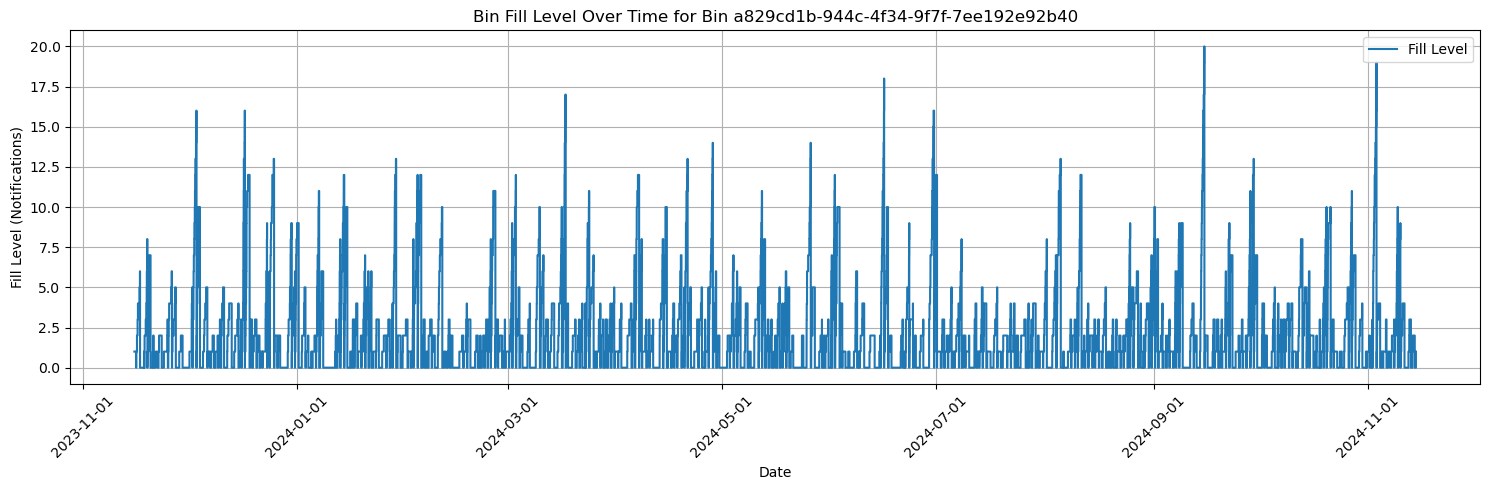

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

inner_square_bins_df = bins_with_types_df.filter(bins_with_types_df.is_in_inner_square == True)
inner_square_bin_uuids = [row['litter_bin_uuid'] for row in inner_square_bins_df.select('litter_bin_uuid').collect()]
random_bin_uuid = random.choice(inner_square_bin_uuids)
print(f"Selected Bin UUID: {random_bin_uuid}")

bin_state_notification_df = spark.read.jdbc(
    url=jdbc_url,
    table="bin_state_notification",
    properties=connection_properties
)
bin_notifications_df = bin_state_notification_df.filter(
    bin_state_notification_df.litter_bin_uuid == random_bin_uuid
).orderBy('point_in_time')

bin_notifications_pd = bin_notifications_df.select(
    'point_in_time', 'notification_type'
).toPandas()
bin_notifications_pd['point_in_time'] = pd.to_datetime(bin_notifications_pd['point_in_time'])
bin_notifications_pd.set_index('point_in_time', inplace=True)

bin_notifications_pd = bin_notifications_pd.sort_index()

fill_levels = []
current_fill_level = 0

for notification_type in bin_notifications_pd['notification_type']:
    if notification_type == 'full':
        current_fill_level += 1  # Increment fill level
    elif notification_type == 'emptied':
        current_fill_level = 0   # Reset fill level to zero
    fill_levels.append(current_fill_level)

bin_notifications_pd['fill_level'] = fill_levels

plt.figure(figsize=(15, 5))
plt.step(
    bin_notifications_pd.index,
    bin_notifications_pd['fill_level'],
    where='post',
    label='Fill Level'
)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.title(f'Bin Fill Level Over Time for Bin {random_bin_uuid}')
plt.xlabel('Date')
plt.ylabel('Fill Level (Notifications)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()